In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
nsamples = 2_048
fs = 44_100

In [2]:
def generate_signal(samples = 2048, fs = 44_100):
    f0, f1, f2, f3, f4 = 1_000, 4_000, 6_000, 8_000, 17_357
    ts = 1 / fs
    time = np.linspace(0, samples*ts, samples)

    tone_0 = 1 * np.sin(2*np.pi*f0*time)
    tone_1 = 0.8 * np.sin(2*np.pi*f1*time)
    tone_2 = 2 * np.sin(2*np.pi*f2*time)
    tone_3 = 0.1 * np.sin(2*np.pi*f3*time)
    tone_4 = 0.3* np.sin(2*np.pi*f4*time)
    signal = tone_0 + tone_1 + tone_2*1j + tone_3*1j + tone_4*1j
    return signal

def compute_fft(data, fs = 44_100):
    samples = len(data)
    ts = 1 / fs
    spectrum = np.fft.fft(signal)
    freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=ts))
    return spectrum, freqs

In [3]:
signal = generate_signal(nsamples, fs)
spectrum, freqs = compute_fft(signal, fs)

E:\AppData\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


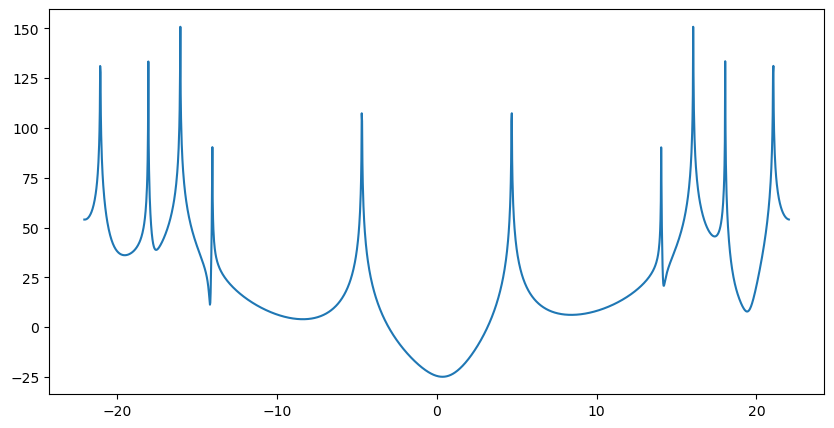

In [4]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(spectrum))

In [5]:
def vector2file_cint16(data: np.array, file: str, plio = 128, bits = 16, scale: bool=True):
    """
    data: samples
    file: output filename
    plio: bit width of the PLIO port
    bits: bit precision per sample
    """
    """Scale signal to use full precision"""
    maxr = np.max(np.abs(data.real))
    maxi = np.max(np.abs(data.imag))
    maxv = maxr if maxr > maxi else maxi
    vscale = 2**int(np.floor(np.log2((1 << (bits-1)) / maxv)))
    data = data * (vscale if scale else 1)
    """Write value to file"""
    with open(file, 'w', newline='') as f:
        for i, v in enumerate(data):
            r = np.int16(v.real)
            c = np.int16(v.imag)
            f.write("{} {} ".format(r, c))
            if (((i+1) % 4) == 0 and plio == 128) or (((i+1) % 2) == 1 and plio == 64):
                f.write('\n')
    
    return vscale

In [6]:
vector2file_cint16(signal, 'DataInFFT0.txt', scale=True)
vector2file_cint16(signal, 'DataInFIR0.txt', scale=True)
vector2file_cint16(spectrum, 'DataOutFFT0.txt', scale=True)

16

In [7]:
#https://stackoverflow.com/questions/37636017/what-is-the-proper-way-to-plot-spectrum-of-a-complex-signal-sampled-in-a-narrow

In [8]:
import csv
def read_file(file: str, samples: int):
    value = np.zeros(samples, dtype=np.complex128)
    count = 0
    with open(file,'r') as f:
        reader = csv.reader(f, delimiter=" ")
        for line in reader:
            if 'T' in line[0]:
                continue
            for i in range(0, len(line), 2):
                if line[i] != '':
                    value[count] = float(line[i]) + 1j* float(line[i+1])
                    count = count + 1
    return value

In [9]:
# Use the output file from the AIE, now using SciPy file for simplicity
signal_read = read_file('DataOutFFT0.txt', nsamples)

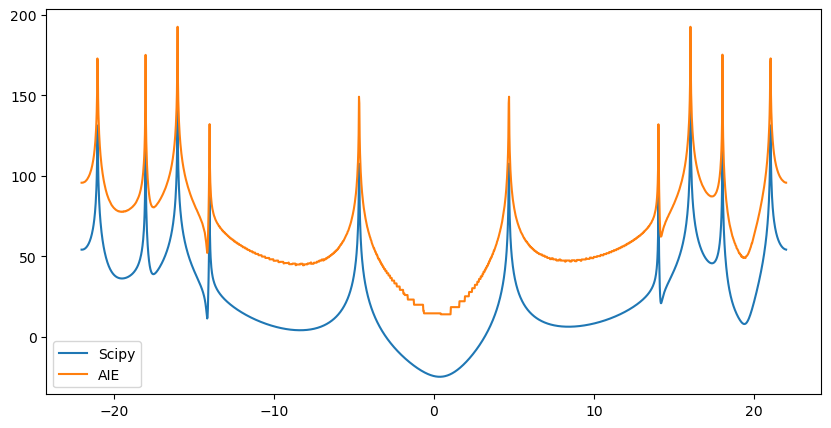

In [10]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy")
plt.plot(freqs / 1e3, 20*np.log(signal_read/2), label="AIE")
plt.legend()

In [11]:
np.array_equal(spectrum, signal_read)

False

In [12]:
np.array_equiv(spectrum, signal_read)

False

In [13]:
np.isclose(spectrum, signal_read, 2, 2)

array([ True,  True,  True, ...,  True,  True,  True])

In [14]:
error = spectrum - signal_read

In [15]:
np.max(np.abs(error.real))

21519.338614608496

In [16]:
np.max(np.abs(error.imag))

18288.695925421747

In [17]:
7464/14

533.1428571428571

In [18]:
def findmax(fftnp, fftaie):
    print(f'Numpy: Max Real {np.max(np.abs(fftnp.real))}, Max Imag {np.max(np.abs(fftnp.imag))}')
    print(f'Numpy: Max Real {np.max(np.abs(fftaie.real))}, Max Imag {np.max(np.abs(fftaie.imag))}')

findmax(spectrum, signal_read)

Numpy: Max Real 1434.6613853915046, Max Imag 1219.3040745782537
Numpy: Max Real 22954.0, Max Imag 19508.0
